### Implémentez un model de scorin (suite):

Ce notbook fait partie du projet 7 de la formation data science. Ici on met en place le suivi du model final sur MLflow.\
Lien de suivi: http://127.0.0.1:5000/#/experiments/900031322788419432/runs/3d4248f77fe2422ab664d3952f172eac

In [ ]:
#Si un moment mlflow ne se lance pas, il faut essayer de redémarer le serveur mlflow
#avec la commande suivante sur un terminal anaconda prompt par exemple:
#activer d'abord l'environement:    conda activate monenvprojet
#se placer dans le repertoir et executer la commande suivante: mlflow server --host 0.0.0.0 --port 5000

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import joblib
import mlflow
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, f1_score, roc_curve
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
#from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [13]:
#path_new_data = notebooks_P7/Data_projet7/new_data/
path_new_data = "C:/Users/aella/Desktop/P7_Model_de_scoring_Abdoullatuf_Maoulida_Aout_2023/Data_P7/New_data/"

In [14]:
import pickle
with open('final_model.pkl', 'rb') as f:
    final_model = pickle.load(f)
#final_model = joblib.load("best_lgbm_3.joblib") 
#best_parameters = joblib.load("best_lgbm_params.joblib")
 

X_test_selected = joblib.load(path_new_data + 'X_test_selected.joblib')
X_train_selected = joblib.load(path_new_data + "X_train_selected.joblib")


y_test_selected = joblib.load(path_new_data + 'y_test_selected.joblib')
y_train_selected = joblib.load(path_new_data + 'y_train_selected.joblib')

In [23]:
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
def custom_metric(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 0.9 * fp / (tn + fp) + 0.1 * fn / (tp + fn)

credit_score_3 = make_scorer(custom_metric, greater_is_better=False)

In [21]:
seed = 42
seuil = 0.70 #optimal_threshold
def eval_metrics(y_true, y_pred_prob, seuil = seuil):
    "y_pred_prob c'est la probabilité qu'un client soit solvable"
    auc_score = roc_auc_score(y_true, y_pred_prob)
    pred = np.where(y_pred_prob > seuil, 1, 0)
    score = custom_metric(y_true, pred) #metric_banking_3(y_true, pred)
    f1score = f1_score(y_true, pred, average='weighted')
    return auc_score, score, f1score

In [26]:
y_pred_prob = final_model.predict_proba(X_test_selected)[:,1]
eval_metrics(y_test_selected, y_pred_prob, seuil = seuil)

(0.7468871199336826, 0.7628552158273382, 0.8870386155811304)

In [27]:
seuil_proba =  0.70 #optimal_threshold
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, class_names, title="Confusion matrix", cmap=plt.cm.Blues, normalize=True):
    """
    This function plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        ylim=(cm.shape[0] - 0.5, -0.5),
        xticklabels=class_names,
        yticklabels=class_names,
        title=title,
        xlabel="Ground truth label",
        ylabel="Predicted label",
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30,
             ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations for both numbers and percentages.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = format(cm[i, j], fmt)
            if normalize:
                text += f" ({cm[i, j]*100:.1f}%)"
            ax.text(
                j,
                i,
                text,
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )
    fig.tight_layout()
    return ax, fig

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

def create_roc_plot(fpr, tpr, model_lgbmc):
    """
    Create ROC curve.
    :param fpr: false positive.
    :param tpr: true positive.
    :return: returns a tuple of plt, fig, ax
    """
    # Calculate AUC score
    probs_lgbmc = model_lgbmc.predict_proba(X_test_selected)[:, 1]
    auc_score = roc_auc_score(y_test_selected, probs_lgbmc)
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
    ax.plot([0, 1], [0, 1], linestyle='--', label='Random guess')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('ROC curve')
    ax.legend()
    
    
    
    return plt, fig, ax

### Expérience 1: LGBMClassifier - modèle optimisé sur le score metier:

100%|█████████████████████████████████████████| 100/100 [11:49:36<00:00, 425.77s/trial, best loss: 0.08285285848172448]


C:\Users\aella\anaconda3\envs\monenvprojet\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


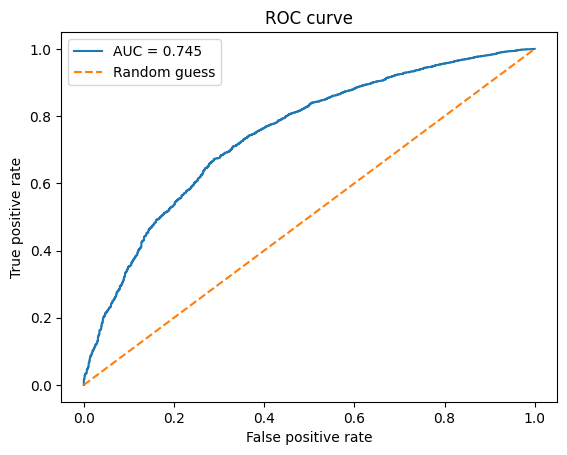

In [38]:
import mlflow

#mlflow.start_run(nested=True)

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment('LGBMC optimisé sur le score métier')
#mlflow.sklearn.autolog() n'est pas supporté par la version sklearn que j'utilise ici

seuil = 0.70 # optimal_threshold

with mlflow.start_run(run_name='HyperOpt_lgbmClassifier', nested=True) as run:
          
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    from sklearn.metrics import precision_score, recall_score
    cv = StratifiedKFold(5)
    seed = 42
    
    # Définir l'espace des hyperparamètres à explorer
    

    # Définir la fonction objectif à minimiser
   #Parameter space
    space = {
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 100, 10),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20),
    'seed': 2023,    # Seed fixe pour la reproductibilité
    'boosting_type': 'gbdt'    # Type d'algorithme boosting
    }
    def objective(params):
        
        #objective function to be minimized. 
        #Hyperopt will seek to minimize the loss returned by this function.

        params = {        
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'num_leaves': int(params['num_leaves']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        'random_state': params['seed'], # Renommons 'seed' en 'random_state'
        'boosting_type': params['boosting_type']     
        }

    
        clf= LGBMClassifier(**params)
        cv = StratifiedKFold(5)
      
        score = cross_val_score(clf, X_train_selected, y_train_selected, scoring=credit_score_3, cv=cv).mean()

       
        return {'loss': -score, 'params': params, 'status': STATUS_OK} 



       # Créer une instance de Trials pour enregistrer les résultats de chaque essai
    trials = Trials()

    # Utiliser l'algorithme TPE (Tree-structured Parzen Estimator) pour l'optimisation
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100,  # Nombre d'essais d'hyperparamètres à effectuer
        trials=trials
    )

        
    clf = LGBMClassifier( #Fit a new model based on the best parameters
                            n_estimators=int(best['n_estimators']), 
                            learning_rate= best['learning_rate'],
                            max_depth= int(best['max_depth']),
                            num_leaves = int(best['num_leaves']),
                            subsample= best['subsample'],
                            colsample_bytree= best['colsample_bytree'],
                            reg_lambda= best['reg_lambda'],
                            boosting_type = 'gbdt',
                            objective = 'binary',
                            random_state = 2023
                            )
    
    # Optimiser ce classifieur sur le jeu d'entraînement
    clf.fit(X_train_selected, y_train_selected)      
    
    y_pred_prob = clf.predict_proba(X_test_selected)[:, 1]

    plot_file = "roc-auc-plot.png"
    fpr, tpr, thresholds = roc_curve(y_test_selected, y_pred_prob)
    plt_roc, fig_roc, ax_roc = create_roc_plot(fpr, tpr,clf)
    fig_roc.savefig(plot_file)

    
    (auc_score, score, f1score) = eval_metrics(y_test_selected, y_pred_prob, seuil = seuil)

    pred = np.where(y_pred_prob > seuil, 1, 0)

    class_names = ["Non Solvable", "Solvable"]
    cf_matrix = metrics.confusion_matrix(y_test_selected, pred)
        

    ax, fig = plot_confusion_matrix(
    cf_matrix, class_names, normalize=False)
    plt.savefig("confusion_matrix.png")
    plt.close(fig)
    
    

#------------------------------------------------------------------------------------------   
    #mlflow.log_dict(best_1, "best_params.json")
    if not best == None:
            for param in best:
                mlflow.log_param(param, best[param]) 
#--------------------------------------------------------------------------    
    mlflow.log_metric("metric_banking", score)
    mlflow.log_metric("AUC", auc_score)
    mlflow.log_metric("f1_score", f1score) 
    mlflow.log_metric("Precision", precision_score(y_test_selected, pred))
    mlflow.log_metric("Recall", recall_score(y_test_selected, pred))
    mlflow.log_artifact("confusion_matrix.png")
    mlflow.log_artifact(plot_file, "roc-auc-plots")
    mlflow.sklearn.log_model(clf, "best_lgbmc")
mlflow.end_run()